# RNN from scratch

## import and process training data

In [1]:
import numpy as np
from data import train_data, test_data

vocab = set()
for text in train_data.keys():
    for w in text.split(" "):
        vocab.add(w)

vocab_size = len(vocab)
print(f'{vocab_size} unique words found')

18 unique words found


In [3]:
# Assign indices to each word so RNN can work with them
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for i, w in enumerate(vocab)}

print(word_to_idx['good'])
print(idx_to_word[0])

1
sad


In [5]:
#each input to the RNN is a vector -> need to represent our vocab as one-hot vectors 
#contain all zeros except for a single one. The “one” is at the word’s corresponding integer index.

def createInputs(text):
    '''
    Returns an array of one-hot vectors representing the words
    in the input text string.
        - text is a string
        - Each one-hot vector has shape (vocab_size, 1)
    '''
    inputs = []
    for w in text.split(" "):
        v = np.zeros((vocab_size, 1))
        v[word_to_idx[w]] = 1
        inputs.append(v)
    return inputs

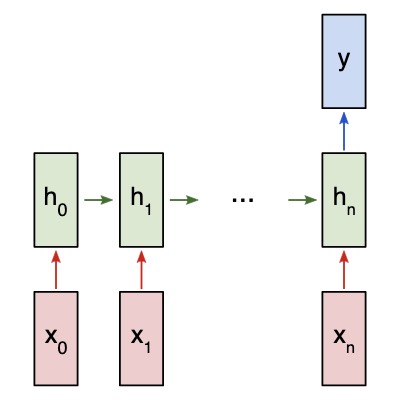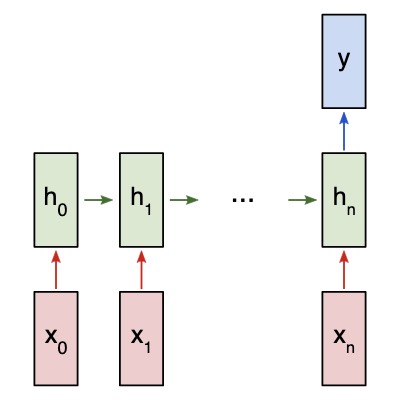

In [92]:
from numpy.random import randn

class RNN:
    
    def __init__(self, input_size, output_size, hidden_size=64):
        #initialize weights
        self.Whh = randn(hidden_size, hidden_size) / 1000 #weight matrix for hidden-to-hidden connections
        self.Wxh = randn(hidden_size, input_size) / 1000 #weight matrix for input-to-hidden connections
        self.Why = randn(output_size, hidden_size) / 1000 #weight matrix for hidden-to-output connections

        #initialize biases (usually set to zero)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
            - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1)) #hidden state vector (same dim as weight matrix). Initialized to zeros.
        
        #multiply inputs by weights (use @ for matrix mulitiplication), add bias, apply activation function (tanh)
        for i, x in enumerate(inputs):
            # x:  A single one-hot input vector (shape (input_size, 1)).
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            #self.Wxh @ x: contribution of the current input to the new hidden state.
            #self.Whh @ h: contribution of the previous hidden state to the new hidden state.
        #calculate output
        y = self.Why @ h + self.by
        return y, h

def softmax(xs):
    # Applies the Softmax Function to the input array.
    return np.exp(xs) / sum(np.exp(xs))

In [94]:
# Initialize RNN
rnn = RNN(vocab_size, 2)

inputs = createInputs('i am very good')
out, h = rnn.forward(inputs)
probs = softmax(out)
print(probs)

[[0.50000044]
 [0.49999956]]


## Train RNN

In [7]:
from numpy.random import randn

class RNN:
    
    def __init__(self, input_size, output_size, hidden_size=64):
        #initialize weights
        self.Whh = randn(hidden_size, hidden_size) / 1000 #weight matrix for hidden-to-hidden connections
        self.Wxh = randn(hidden_size, input_size) / 1000 #weight matrix for input-to-hidden connections
        self.Why = randn(output_size, hidden_size) / 1000 #weight matrix for hidden-to-output connections

        #initialize biases (usually set to zero)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
            - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1)) #hidden state vector (same dim as weight matrix). Initialized to zeros.
        self.last_inputs = inputs #store for use in backprop
        self.last_hs = {0: h} #store for use in backprop
        
        #multiply inputs by weights (use @ for matrix mulitiplication), add bias, apply activation function (tanh)
        for i, x in enumerate(inputs):
            # x:  A single one-hot input vector (shape (input_size, 1)).
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            #self.Wxh @ x: contribution of the current input to the new hidden state.
            #self.Whh @ h: contribution of the previous hidden state to the new hidden state.
            
            #store values of all hidden stats in tthe self.last_hs dict.
            self.last_hs[i + 1] = h
            
        #calculate output
        y = self.Why @ h + self.by
        
        return y, h

    def backprop(self,d_y, learn_rate=2e-2):
        '''
        Perform a backward pass of the RNN.
            - d_y (dL/dy) has shape (output_size, 1).
            - learn_rate is a float.
        '''
        n = len(self.last_inputs)

        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y

        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        # Calculate dL/dh for the last h.
        d_h = self.Why.T @ d_y

        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

            # dL/db = dL/dh * (1 - h^2)
            d_bh += temp

            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += temp @ self.last_hs[t].T

            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += temp @ self.last_inputs[t].T

            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp

        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d) #values below -1 or above 1 are clipped. This helps mitigate the exploding gradient problem

            # Update weights and biases using gradient descent.
            self.Whh -= learn_rate * d_Whh
            self.Wxh -= learn_rate * d_Wxh
            self.Why -= learn_rate * d_Why
            self.bh -= learn_rate * d_bh
            self.by -= learn_rate * d_by

def softmax(xs):
    # Applies the Softmax Function to the input array.
    return np.exp(xs) / sum(np.exp(xs))

In [51]:
import random

def processData(data, backprop=True):
    '''
    Helper function. Returns the RNN's loss and accuracy for the given data.
    - data is a dictionary mapping text to True or False.
    - backprop determines if the backward phase should be run.
    '''
    items = list(data.items())
    random.shuffle(items)

    loss_sum = 0  # Accumulate loss
    num_correct = 0

    for x, y in items:
        inputs = createInputs(x)
        target = int(y)

        # Forward
        out, _ = rnn.forward(inputs)
        probs = softmax(out)

        # Calculate loss / accuracy
        loss_sum -= np.log(probs[target, 0])  # Access scalar value
        num_correct += int(np.argmax(probs) == target)

        if backprop:
            # Build dL/dy
            d_L_d_y = probs.copy()  # Create a copy to avoid modifying probs directly
            d_L_d_y[target, 0] -= 1  #  Important:  Subtract 1 from the correct element *and* ensure it is a scalar.

            # Backward
            rnn.backprop(d_L_d_y)

    # Return the *average* loss and accuracy over the dataset.
    return loss_sum / len(data), num_correct / len(data)

In [53]:
#initialize rnn
rnn = RNN(vocab_size, 2)

In [55]:
# Training loop
for epoch in range(1000):
  train_loss, train_acc = processData(train_data)

  if epoch % 100 == 99:
    print(f'--- Epoch {epoch + 1}')
    print(f'Train:\tLoss {train_loss:.3f} | Accuracy: {train_acc:.3f}')

    test_loss, test_acc = processData(test_data, backprop=False)
    print(f'Test:\tLoss {test_loss:.3f} | Accuracy: {test_acc:.3f}')

--- Epoch 100
Train:	Loss 0.683 | Accuracy: 0.569
Test:	Loss 0.756 | Accuracy: 0.500
--- Epoch 200
Train:	Loss 0.010 | Accuracy: 1.000
Test:	Loss 0.009 | Accuracy: 1.000
--- Epoch 300
Train:	Loss 0.002 | Accuracy: 1.000
Test:	Loss 0.002 | Accuracy: 1.000
--- Epoch 400
Train:	Loss 0.001 | Accuracy: 1.000
Test:	Loss 0.001 | Accuracy: 1.000
--- Epoch 500
Train:	Loss 0.001 | Accuracy: 1.000
Test:	Loss 0.001 | Accuracy: 1.000
--- Epoch 600
Train:	Loss 0.000 | Accuracy: 1.000
Test:	Loss 0.001 | Accuracy: 1.000
--- Epoch 700
Train:	Loss 0.000 | Accuracy: 1.000
Test:	Loss 0.000 | Accuracy: 1.000
--- Epoch 800
Train:	Loss 0.000 | Accuracy: 1.000
Test:	Loss 0.000 | Accuracy: 1.000
--- Epoch 900
Train:	Loss 0.000 | Accuracy: 1.000
Test:	Loss 0.000 | Accuracy: 1.000
--- Epoch 1000
Train:	Loss 0.000 | Accuracy: 1.000
Test:	Loss 0.000 | Accuracy: 1.000
